Install Module

In [1]:
!pip install tensorflow numpy scikit-learn matplotlib

Import Library dan Preprocessing Data

In [1]:
# Impor library
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import json
import re
import matplotlib.pyplot as plt


Read dataset

In [2]:
# Unggah file multi_turn_dialog.json ke Google Colab atau gunakan kode di bawah ini untuk membaca file
from google.colab import files
uploaded = files.upload()

# Baca file JSON
with open('multi_turn_dialog.json', 'r') as file:
    data = json.load(file)

# Tampilkan beberapa contoh data
print(data[:2])  # Lihat contoh dialog


Saving multi_turn_dialog.json to multi_turn_dialog.json
[{'dialog': [{'user': 'Arifian, apa yang bisa kamu ceritakan tentang dirimu?', 'bot': 'Nama saya Arifian Saputra. Saya berumur 22 tahun dan lahir pada tanggal 7 Januari 2002. Saya adalah seorang Mentor di IBM Advance AI di Infinite Learning. Saya tinggal di Batam dan hobi saya adalah bermain game dan mendengarkan musik.'}, {'user': 'Arifian, berapa umurmu?', 'bot': 'Saya berumur 22 tahun.'}, {'user': 'Arifian, kapan kamu lahir?', 'bot': 'Saya lahir pada tanggal 7 Januari 2002.'}]}, {'dialog': [{'user': 'Apa pekerjaanmu, Arifian?', 'bot': 'Saya adalah seorang Mentor untuk IBM Advance AI di Infinite Learning.'}, {'user': 'Dimana kamu tinggal, Arifian?', 'bot': 'Saya tinggal di Batam, Indonesia.'}, {'user': 'Arifian, apa hobi kamu?', 'bot': 'Hobi saya adalah bermain game dan mendengarkan musik.'}]}]


Preprocessing data

In [3]:
# Menggabungkan semua teks (input dan respons) untuk tokenisasi
all_sentences = []
for dialog in data:
    for turn in dialog['dialog']:
        all_sentences.append(turn['user'])
        all_sentences.append(turn['bot'])

# Tokenisasi teks
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(all_sentences)
vocab_size = len(tokenizer.word_index) + 1

# Mengonversi teks ke urutan angka
input_sequences = []
output_sequences = []
for dialog in data:
    for turn in dialog['dialog']:
        input_seq = tokenizer.texts_to_sequences([turn['user']])[0]
        output_seq = tokenizer.texts_to_sequences([turn['bot']])[0]
        input_sequences.append(input_seq)
        output_sequences.append(output_seq)

# Padding sequences agar semua memiliki panjang yang sama
max_sequence_length = max(len(seq) for seq in input_sequences + output_sequences)
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='post')
output_sequences = pad_sequences(output_sequences, maxlen=max_sequence_length, padding='post')

# Tampilkan beberapa kata dari tokenizer untuk memastikan kata-kata penting ada
print("Kata-kata dalam tokenizer:", list(tokenizer.word_index.keys())[:50])



Kata-kata dalam tokenizer: ['<OOV>', 'saya', 'yang', 'dan', 'kamu', 'arifian', 'apa', 'di', 'untuk', 'dalam', 'ai', 'teknologi', 'dengan', 'bagaimana', 'adalah', 'menggunakan', 'ini', 'sebagai', 'dari', 'tailwindcss', 'proyek', 'melihat', 'bisa', 'mentor', 'siswa', 'web', 'membantu', 'pada', 'bidang', 'lebih', 'pengembangan', 'karena', 'memahami', 'data', 'framework', 'baru', 'orang', 'memilih', 'paling', 'learning', 'musik', 'saat', 'tantangan', 'seperti', 'react', 'hobi', 'game', 'suka', 'lain', 'banyak']


LSTM Model Building

In [4]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.2),
    LSTM(128),
    Dense(128, activation='relu'),
    Dense(vocab_size, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         84864     
                                                                 
 bidirectional (Bidirection  (None, None, 256)         263168    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, None, 256)         0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 663)               85527     
                                                        

Train the model

In [5]:
# Pastikan y_train hanya berisi indeks kata terakhir dari setiap urutan output
y_train = np.array([seq[-1] for seq in output_sequences])

# Verifikasi panjang input dan output
print("Jumlah sampel input:", len(input_sequences))
print("Jumlah sampel target (y_train):", len(y_train))

# Bagi data menjadi training dan validation
X_train, X_val, y_train, y_val = train_test_split(input_sequences, y_train, test_size=0.2, random_state=42)

# Cek bentuk data setelah pembagian
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), batch_size=32)

Jumlah sampel input: 127
Jumlah sampel target (y_train): 127
X_train shape: (101, 39)
y_train shape: (101,)
X_train shape: (101, 39)
y_train shape: (101,)
Epoch 1/50
4/4 [==============================] - 6s 441ms/step - loss: 6.4485 - accuracy: 0.6832 - val_loss: 6.1536 - val_accuracy: 0.9615
Epoch 2/50
4/4 [==============================] - 0s 88ms/step - loss: 5.6892 - accuracy: 1.0000 - val_loss: 4.1283 - val_accuracy: 0.9615
Epoch 3/50
4/4 [==============================] - 0s 86ms/step - loss: 3.3910 - accuracy: 1.0000 - val_loss: 1.9272 - val_accuracy: 0.9615
Epoch 4/50
4/4 [==============================] - 0s 85ms/step - loss: 1.1926 - accuracy: 1.0000 - val_loss: 0.5163 - val_accuracy: 0.9615
Epoch 5/50
4/4 [==============================] - 0s 84ms/step - loss: 0.1130 - accuracy: 1.0000 - val_loss: 0.4401 - val_accuracy: 0.9615
Epoch 6/50
4/4 [==============================] - 0s 86ms/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.5162 - val_accuracy: 0.9615
Epoch 7/50

Training result visualization

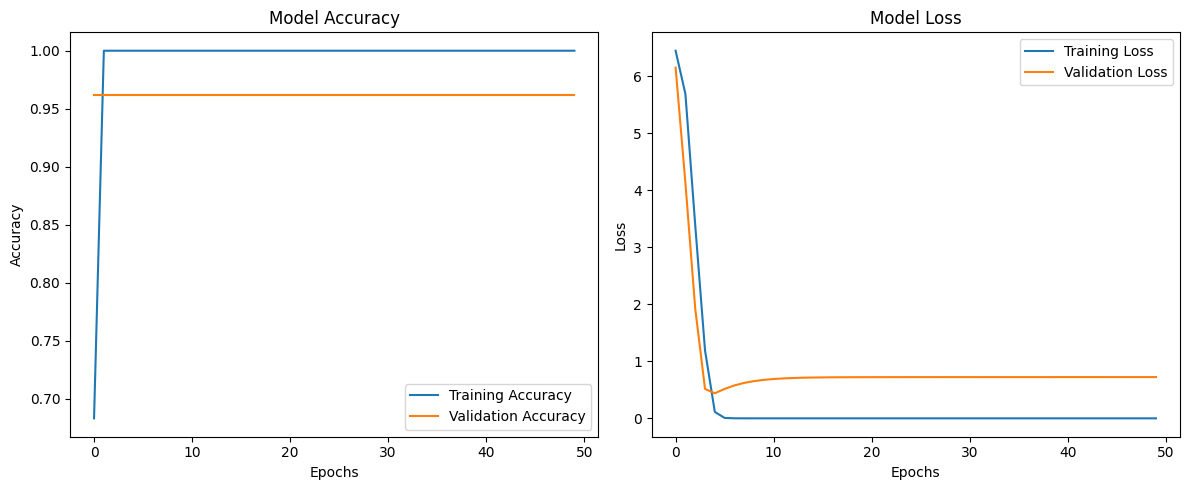

In [6]:
import matplotlib.pyplot as plt

# Plot akurasi model selama pelatihan
plt.figure(figsize=(12, 5))

# Plot akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Menampilkan plot
plt.tight_layout()
plt.show()


Test the model

In [11]:
def generate_response(input_text):
    input_seq = tokenizer.texts_to_sequences([input_text])
    input_seq = pad_sequences(input_seq, maxlen=max_sequence_length, padding='post')

    # Prediksi output
    predicted_seq = model.predict(input_seq)

    # Debug: Tampilkan distribusi probabilitas
    print("Distribusi prediksi:", predicted_seq[0])

    predicted_word_index = np.argmax(predicted_seq, axis=-1)[0]  # Mengambil satu indeks output

    # Konversi indeks ke kata
    response_word = tokenizer.index_word.get(predicted_word_index, '<UNK>')

    return response_word

# Uji chatbot
user_input = "Berapa umurmu?"
print("Chatbot response:", generate_response(user_input))


1/1 [==============================] - 0s 33ms/step
Distribusi prediksi: [9.99994397e-01 1.03078142e-08 2.06852668e-09 2.62111932e-09
 1.04791695e-08 3.42445738e-09 1.26404544e-07 9.88021664e-09
 1.64143754e-09 1.32319364e-08 1.24443156e-09 3.69591935e-09
 2.31690805e-10 2.81949419e-09 3.73377018e-09 3.90995858e-09
 1.66650427e-09 1.09289111e-09 1.52645518e-09 3.53779228e-10
 1.72595660e-09 7.17757676e-09 1.98647392e-08 2.17075673e-08
 8.79143514e-09 1.42508672e-08 1.41333061e-08 2.79243495e-09
 3.61694283e-08 1.93514138e-09 9.74948899e-10 1.07678959e-08
 3.34414119e-09 1.24013866e-08 4.27300595e-09 2.87861535e-09
 6.49015419e-09 5.80895221e-10 1.66210767e-09 9.38902467e-09
 9.99408822e-09 6.73260869e-09 1.79316439e-09 6.89282009e-09
 2.96330427e-09 5.16192289e-09 5.86786064e-10 2.14737419e-08
 3.84809917e-09 1.22367005e-08 3.30111716e-09 1.40151035e-09
 1.83558990e-09 1.16660503e-09 5.25054389e-10 2.58271826e-09
 7.60882746e-10 8.65359673e-10 8.35981895e-10 6.02880146e-09
 6.22028651e